# Numbers
The main goal of this exercise is to train a diffusion model to generate mnist images.

In [1]:
import torch
import diffusers
import matplotlib.pyplot as plt
from torchvision import transforms, datasets

from PIL import Image
import numpy as np

## Data
Download, transform and import images from dataset to program

In [2]:
image_size = 32
preprocess = transforms.Compose([
    transforms.Resize([image_size,image_size]),
    transforms.ToTensor()
])

In [3]:
mnist_dataset = datasets.MNIST(
    root="Mnist_dataset",
    download=True,
    train=True,
    transform=preprocess
)


In [4]:
train,val,test = torch.utils.data.random_split(mnist_dataset,(0.8,0.1,0.1))

batch_size = 256
train_loader = torch.utils.data.DataLoader(
    dataset=train,
    shuffle=True,
    batch_size=batch_size
)

val_loader = torch.utils.data.DataLoader(
    dataset=val,
    shuffle=True,
    batch_size=batch_size
)

# test_loader = torch.utils.data.DataLoader(
#     dataset=test,
#     shuffle=True,
#     batch_size=batch_size
# )



### A little fnct to show easily images

In [5]:
def show_images(images_tensor:torch.tensor):
    n_dims = images_tensor.dim()
    
    if n_dims in (2,3):
        x_cat = images_tensor

    elif n_dims == 4:
        x_list = [img for img in images_tensor]
        x_cat = torch.cat(x_list,dim=2)
    
    else:
        raise SyntaxError("The dimensions of images_tensor must be between 2 and 4")

    if n_dims != 2:
        if x_cat.shape[0] == 1:
            plt.imshow(x_cat.movedim(0,-1),cmap="gray");
        else:
            plt.imshow(x_cat.movedim(0,-1));
    else:
        plt.imshow(x_cat,cmap="gray");

In [6]:
def show_images_list(images_list:list[torch.Tensor]) -> None:

    images_tensor = torch.concat(images_list,dim=0)

    # return images_tensor
    show_images(images_tensor.unsqueeze(1))

## Add Noise

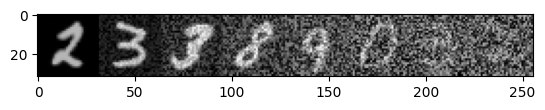

In [7]:
scheduler = diffusers.DDPMScheduler(
    num_train_timesteps=1000, beta_start=0.0001, beta_end=0.0065
)

# Create a tensor with 8 evenly spaced values from 0 to 999
timesteps = torch.linspace(0, 999, 8).long()

# We load 8 images from the dataset and
# add increasing amounts of noise to them
batch = next(iter(train_loader))
x = batch[0][:8]
noise = torch.rand_like(x)
noised_x = scheduler.add_noise(x, noise, timesteps)

show_images(noised_x)

## U-Net

In [8]:
from diffusers import UNet2DModel

model = UNet2DModel(
    in_channels=1,  # 1 channels for grey scale
    sample_size=image_size,  # Specify our input size
    # The number of channels per block affects the model size
    block_out_channels=(32, 64, 128, 256),
    down_block_types=(
        "DownBlock2D",
        "DownBlock2D",
        "AttnDownBlock2D",
        "AttnDownBlock2D",
    ),
    up_block_types=(
        "AttnUpBlock2D",
        "AttnUpBlock2D",
        "UpBlock2D",
        "UpBlock2D"
        ),
    out_channels=1

).cuda()

# Pass a batch of data through to make sure it works. The dimensions of tensors must be the same
with torch.inference_mode():
    out = model(noised_x.cuda(), timestep=timesteps.cuda()).sample

print(noised_x.shape)
print(out.shape)

2026-02-21 12:09:05.182248: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-21 12:09:05.196810: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1771672145.214213    7227 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1771672145.218774    7227 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2026-02-21 12:09:05.240009: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

torch.Size([8, 1, 32, 32])
torch.Size([8, 1, 32, 32])


## Training Loops

In [9]:
from torch.nn import functional as F
n_epochs = 5
lr = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr = lr)
loss_fn = F.mse_loss
losses = []

In [10]:
from torch import nn
def train_loop(loader:torch.utils.data.DataLoader, model : nn.Module, scheduler: diffusers.schedulers, optimizer:torch.optim, loss_fn:callable):
    nlotes = len(loader)
    # train_size = len(loader.dataset)

    model.train()   #Preparo el modelo para el entrenamiento

    train_losses = 0
    losses_list = []


    for nlote,x in enumerate(loader):
        x = x[0].cuda()

        ## Noise
        # Make noise
        noise = torch.randn_like(x).cuda()

        # Create random timesteps to the training
        timesteps = torch.randint(
            0,
            scheduler.config.num_train_timesteps,
            (x.shape[0],)
        ).long().cuda()

        # Add Noise to images
        noisy_x = scheduler.add_noise(x,noise,timesteps)

        ## Forward Pass
        noise_pred = model(noisy_x, timesteps, return_dict = False)[0]
        
        
        ## Back-propagation
        # Calc of loss
        loss = loss_fn(noise_pred, noise)    #Calculo de loss
        
        # Save Loss
        losses_list.append(loss.item())

        # Steps of training
        loss.backward()             #Calculo de gradiente
        optimizer.step()            #Actualización de parámetros
        optimizer.zero_grad()       #Limpieza del optimizador

        #Guardamos algunas características para plotear al final
        train_losses += loss.item()

        #Muestra del proceso
        if nlote % 10 == 0:
            print("Nº de lote:\t",nlote)
            print("Loss:\t\t\t",loss.item())
            print()

    train_losses /= nlotes
    print()
    print("\tLoss Promedio")
    print(f"\tEntrenamiento: {train_losses:>8f}")

    return losses_list

In [11]:
def val_loop(loader:torch.utils.data.DataLoader, model:nn.Module, scheduler: diffusers.schedulers, loss_fn:callable):
    
    nlotes = len(loader)

    model.eval()         #Preparo el modelo para inferencia

    val_losses = 0
    losses_list = []

    with torch.inference_mode():       #Cancelo el calculo del gradiente
        for x in loader:
            
            x = x[0].cuda()

            ## Noise
            noise = torch.randn_like(x)

            timesteps = torch.randint(
                0,
                scheduler.config.num_train_timesteps,
                (x.shape[0],)
            ).long().cuda()

            noisy_x = scheduler.add_noise(x, noise, timesteps)

            noise_pred = model(noisy_x, timesteps, return_dict=False)[0]       # Inferencia
            
            loss = loss_fn(noise_pred, noise)

            val_losses += loss.item()
            losses_list.append(loss.item())

    val_losses /= nlotes

    print(f"\tValidación: {val_losses:>8f}")

    return losses_list


## The training

In [12]:
train_loss = []
val_loss = []
for epoch in range(n_epochs):
    print(f"Iteración: {(epoch + 1)} / {n_epochs} -----------------------------")
    
    #Train
    train_loss  += train_loop(train_loader,model,scheduler,optimizer,loss_fn)
    
    #Validation
    val_output = val_loop(val_loader,model,scheduler,loss_fn)
    val_loss += val_output

print("Finalizado entrenamiento del modelo!")

Iteración: 1 / 5 -----------------------------
Nº de lote:	 0
Loss:			 1.2361801862716675

Nº de lote:	 10
Loss:			 0.5138868093490601

Nº de lote:	 20
Loss:			 0.2602360248565674

Nº de lote:	 30
Loss:			 0.17924582958221436

Nº de lote:	 40
Loss:			 0.14458534121513367

Nº de lote:	 50
Loss:			 0.13575932383537292

Nº de lote:	 60
Loss:			 0.12647175788879395

Nº de lote:	 70
Loss:			 0.10792063921689987

Nº de lote:	 80
Loss:			 0.10174118727445602

Nº de lote:	 90
Loss:			 0.08702480792999268

Nº de lote:	 100
Loss:			 0.08694666624069214

Nº de lote:	 110
Loss:			 0.07271068543195724

Nº de lote:	 120
Loss:			 0.0762036144733429

Nº de lote:	 130
Loss:			 0.07065494358539581

Nº de lote:	 140
Loss:			 0.06926587224006653

Nº de lote:	 150
Loss:			 0.061024561524391174

Nº de lote:	 160
Loss:			 0.06579628586769104

Nº de lote:	 170
Loss:			 0.05990362539887428

Nº de lote:	 180
Loss:			 0.060092419385910034


	Loss Promedio
	Entrenamiento: 0.151796
	Validación: 0.055099
Iteración:

In [ ]:
torch.save(model.state_dict(),"Mnist_train.pth")

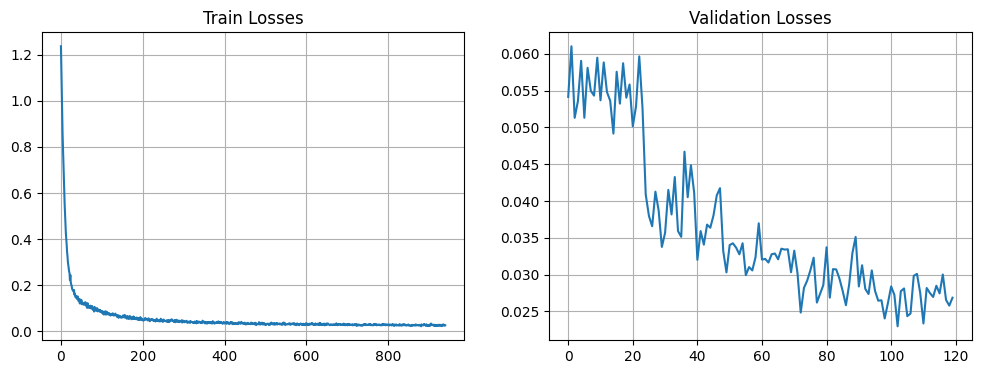

In [13]:
plt.subplots(1,2,figsize=(12,4))

plt.subplot(1,2,1)
plt.title("Train Losses")
plt.plot(range(len(train_loss)),train_loss);
plt.grid()

plt.subplot(1,2,2)
plt.title("Validation Losses")
plt.plot(range(len(val_loss)),val_loss);
plt.grid()

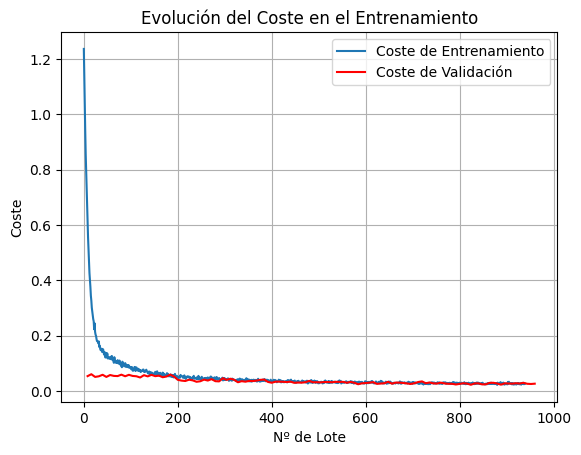

In [14]:
plt.title("Evolución del Coste en el Entrenamiento")
plt.plot(range(len(train_loss)),train_loss,range(8,(len(val_loss)+1)*8,8),val_loss,"r");
plt.grid()
plt.xlabel("Nº de Lote")
plt.ylabel("Coste")

plt.legend(["Coste de Entrenamiento", "Coste de Validación"]);


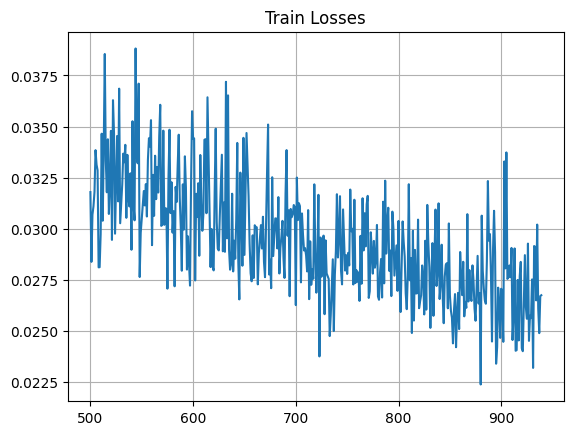

In [15]:
plt.title("Train Losses")
plt.plot(range(500,len(train_loss)),train_loss[500:]);
plt.grid()

## Generations of images

In [24]:
pipeline = diffusers.DDPMPipeline(unet=model, scheduler=scheduler)
ims = pipeline(batch_size=8).images

  0%|          | 0/1000 [00:00<?, ?it/s]

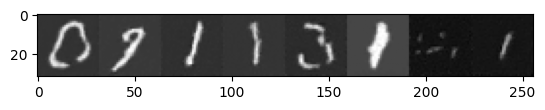

In [25]:
ToTensor = transforms.ToTensor()
imgs_tensor = [ToTensor(img) for img in ims]
show_images_list(images_list=imgs_tensor)

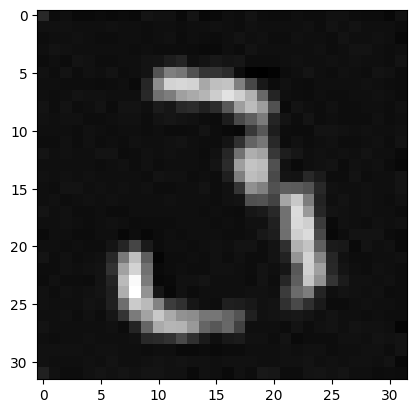

In [27]:
show_images(imgs_tensor[4])